### Supervised Contrastive Learning + MLP

### Connect Google Drive

In [ ]:
# Connecting Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive/MyDrive

/content/gdrive/MyDrive


### Install Neccessary Libraries

In [ ]:
# Install Libraries
%%capture
!pip install datasets
!pip install huggingface_hub
!pip install tensorboard_logger

### Imports

In [ ]:
# Import Libraries

# General
import gc
import os
import sys
import time
import math
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt

# Matrix Manipulation
import numpy as np
import pandas as pd

# Image Handling
from torchvision.transforms import transforms
from torchvision import transforms, datasets

# Dataset
import huggingface_hub
from datasets import load_dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Model Building
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tensorboard_logger as tb_logger

# Training Utility
try:
  import apex
  from apex import amp, optimizers
except ImportError:
  pass

# Random Seed
np.random.seed(0)

### Load and Prepare Data

In [ ]:
# # HuggingFace Login to access the data
# huggingface_hub.notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


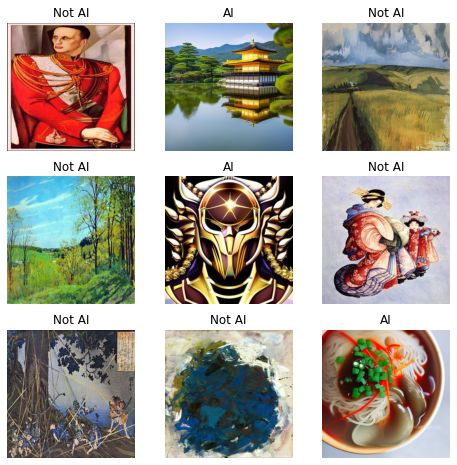

In [ ]:
# Load Train Data
dataset = load_dataset('competitions/aiornot', split='train')

# Visualize Dataset
labels_map = {
    0: "Not AI",
    1: "AI"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    _, img, label = dataset[sample_idx].values()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

# DataLoader to load data
BATCH_SIZE = 512
IMAGE_SIZE = 64

# -- Preprocess Images
preprocess = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

def collate_fn(data):
  return torch.stack([preprocess(x['image']) for x in data]), torch.tensor([x['label'] for x in data])
  
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

### Mean and Standard Deviation of the Dataset

In [ ]:
# COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, _ in tqdm(dataloader):
  # inputs have shape BS x 3 x H x W
  psum    += inputs.sum(axis        = [0, 2, 3])
  psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 37/37 [01:44<00:00,  2.82s/it]


In [ ]:
#FINAL CALCULATIONS

# pixel count
count = len(dataset) * IMAGE_SIZE * IMAGE_SIZE

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4843, 0.4339, 0.3911])
std:  tensor([0.2712, 0.2654, 0.2686])


In [ ]:
%cd Fatima-Fellowship-Challenge/
# os.mkdir('Data')
# os.mkdir('Data/0')
# os.mkdir('Data/1')

/content/gdrive/MyDrive/Fatima-Fellowship-Challenge


In [ ]:
# # creating the file structure for Supervised Contrastive Learning
# for data in tqdm(dataset):
#   if data['label'] == 0:
#     data['image'].save(f"Data/0/{data['id']}")
#   else:
#     data['image'].save(f"Data/1/{data['id']}")

100%|██████████| 18618/18618 [05:30<00:00, 56.25it/s]


### Supervised Contrastive Learning

Set up some parameters

In [ ]:
# training
PRINT_FREQ = 10
SAVE_FREQ = 1
BATCH_SIZE = 32
NUM_WORKER = 0
EPOCHS = 100

# optimization
LEARNING_RATE = 0.05
LR_DECAY_EPOCHS = (70, 80, 90)
LR_DECAY_RATE = 0.1
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9

# model dataset
MODEL = 'resnet152'
DATASET = 'AIorNot'
MEAN = (0.4843, 0.4339, 0.3911) 
STD = (0.2712, 0.2654, 0.2686) 
DATA_FOLDER = 'Data' 
SIZE = 32

# method
METHOD = 'SupCon'

# temperature
TEMP = 0.7

# other setting
COSINE = True
TRIAL = 0

In [ ]:
# set the path according to the environment
if DATA_FOLDER is None:
  DATA_FOLDER = './datasets/'
MODEL_PATH = './save/SupCon/{}_models'.format(DATASET)
TB_PATH = './save/SupCon/{}_tensorboard'.format(DATASET)

MODEL_NAME = '{}_{}_{}_lr_{}_decay_{}_bsz_{}_temp_{}_trial_{}'.\
    format(METHOD, DATASET, MODEL, LEARNING_RATE,
            WEIGHT_DECAY, BATCH_SIZE, TEMP, TRIAL)

if COSINE:
  MODEL_NAME = '{}_cosine'.format(MODEL_NAME)

TB_FOLDER = os.path.join(TB_PATH, MODEL_NAME)
if not os.path.isdir(TB_FOLDER):
  os.makedirs(TB_FOLDER)

SAVE_FOLDER = os.path.join(MODEL_PATH, MODEL_NAME)
if not os.path.isdir(SAVE_FOLDER):
  os.makedirs(SAVE_FOLDER)

Model

In [ ]:
class SupConResNet(nn.Module):
  """backbone + projection head"""
  def __init__(self, name=MODEL, head='mlp', feat_dim=512):
    super(SupConResNet, self).__init__()
    self.encoder, dim_in = torch.hub.load('pytorch/vision:v0.10.0', MODEL, pretrained=True), 2048
    self.encoder.fc = nn.Identity()
    
    self.encoder.eval()
    
    if head == 'linear':
      self.head = nn.Linear(dim_in, feat_dim)
    elif head == 'mlp':
      self.head = nn.Sequential(
          nn.Linear(dim_in, dim_in),
          nn.ReLU(inplace=True),
          nn.Linear(dim_in, dim_in//2),
          nn.ReLU(inplace=True),
          nn.Linear(dim_in//2, feat_dim)
      )
    else:
      raise NotImplementedError(
          'head not supported: {}'.format(head))

  def forward(self, x):
    feat = self.encoder(x)
    feat = F.normalize(self.head(feat), dim=1)
    return feat

Loss

In [ ]:
class SupConLoss(nn.Module):
  """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf."""
  def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
    super(SupConLoss, self).__init__()
    self.temperature = temperature
    self.contrast_mode = contrast_mode
    self.base_temperature = base_temperature

  def forward(self, features, labels=None, mask=None):
    """Compute loss for model. If both `labels` and `mask` are None,
    it degenerates to SimCLR unsupervised loss: https://arxiv.org/pdf/2002.05709.pdf
    Args:
        features: hidden vector of shape [bsz, n_views, ...].
        labels: ground truth of shape [bsz].
        mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
            has the same class as sample i. Can be asymmetric.
    Returns:
        A loss scalar.
    """
    device = (torch.device('cuda')
              if features.is_cuda
              else torch.device('cpu'))

    if len(features.shape) < 3:
      raise ValueError('`features` needs to be [bsz, n_views, ...],'
                        'at least 3 dimensions are required')
    if len(features.shape) > 3:
      features = features.view(features.shape[0], features.shape[1], -1)

    batch_size = features.shape[0]
    if labels is not None and mask is not None:
      raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
      mask = torch.eye(batch_size, dtype=torch.float32).to(device)
    elif labels is not None:
      labels = labels.contiguous().view(-1, 1)
      if labels.shape[0] != batch_size:
        raise ValueError('Num of labels does not match num of features')
      mask = torch.eq(labels, labels.T).float().to(device)
    else:
      mask = mask.float().to(device)

    contrast_count = features.shape[1]
    contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
    if self.contrast_mode == 'one':
      anchor_feature = features[:, 0]
      anchor_count = 1
    elif self.contrast_mode == 'all':
      anchor_feature = contrast_feature
      anchor_count = contrast_count
    else:
      raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

    # compute logits
    anchor_dot_contrast = torch.div(
        torch.matmul(anchor_feature, contrast_feature.T),
        self.temperature)
    # for numerical stability
    logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
    logits = anchor_dot_contrast - logits_max.detach()

    # tile mask
    mask = mask.repeat(anchor_count, contrast_count)
    # mask-out self-contrast cases
    logits_mask = torch.scatter(
        torch.ones_like(mask),
        1,
        torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
        0
    )
    mask = mask * logits_mask

    # compute log_prob
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

    # compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

    # loss
    loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
    loss = loss.view(anchor_count, batch_size).mean()

    return loss

Image Augmentation and Utility Functions

In [ ]:
class TwoCropTransform:
  """Create two crops of the same image"""
  def __init__(self, transform):
    self.transform = transform

  def __call__(self, x):
    return [self.transform(x), self.transform(x)]


class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

Training Utils

In [ ]:
def adjust_learning_rate(optimizer, epoch):
  lr = LEARNING_RATE
  if COSINE:
    eta_min = lr * (LR_DECAY_RATE ** 3)
    lr = eta_min + (lr - eta_min) * (
            1 + math.cos(math.pi * epoch / EPOCHS)) / 2
  else:
    steps = np.sum(epoch > np.asarray(LR_DECAY_EPOCHS))
    if steps > 0:
        lr = lr * (LR_DECAY_RATE ** steps)

  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

def set_optimizer(model):
  optimizer = optim.SGD(model.parameters(),
                      lr=LEARNING_RATE,
                      momentum=MOMENTUM,
                      weight_decay=WEIGHT_DECAY)
  return optimizer


def save_model(model, optimizer, epoch, save_file):
  print('==> Saving...')
  state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
  }
  torch.save(state, save_file)
  del state

def set_loader():
  mean = MEAN
  std = STD

  normalize = transforms.Normalize(mean=mean, std=std)

  train_transform = transforms.Compose([
      transforms.Resize(64),
      transforms.RandomResizedCrop(size=SIZE, scale=(0.2, 1.)),
      transforms.ToTensor(),
      normalize,
  ])

  train_dataset = datasets.ImageFolder(root=DATA_FOLDER, transform=TwoCropTransform(train_transform))
  
  train_sampler = None
  train_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size=BATCH_SIZE, shuffle=(train_sampler is None),
      num_workers=NUM_WORKER, pin_memory=True, sampler=train_sampler)

  return train_loader


def set_model():
  model = SupConResNet(name='resnet18')
  criterion = SupConLoss(temperature=TEMP)

  if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
      model.encoder = torch.nn.DataParallel(model.encoder)
    model = model.cuda()
    criterion = criterion.cuda()
    cudnn.benchmark = True

  return model, criterion

# Frees up GPU, when running inference in a loop, to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()

def train(train_loader, model, criterion, optimizer, epoch):
  """one epoch training"""
  model.train()

  batch_time = AverageMeter()
  data_time = AverageMeter()
  losses = AverageMeter()

  end = time.time()
  for idx, (images, labels) in enumerate(train_loader):
    data_time.update(time.time() - end)

    images = torch.cat([images[0], images[1]], dim=0)
    if torch.cuda.is_available():
      images = images.cuda(non_blocking=True)
      labels = labels.cuda(non_blocking=True)
    bsz = labels.shape[0]

    # compute loss
    features = model(images)
    f1, f2 = torch.split(features, [bsz, bsz], dim=0)
    features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
    loss = criterion(features, labels)

    # update metric
    losses.update(loss.item(), bsz)

    # SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

    # print info
    if (idx + 1) % PRINT_FREQ == 0:
      print('Train: [{0}][{1}/{2}]\t'
            'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'loss {loss.val:.3f} ({loss.avg:.3f})'.format(
              epoch, idx + 1, len(train_loader), batch_time=batch_time,
              data_time=data_time, loss=losses))
      sys.stdout.flush()
  
    optimize_gpu()

  return losses.avg

Training

In [ ]:
# build data loader
train_loader = set_loader()

# build model and criterion
model, criterion = set_model()

# build optimizer
optimizer = set_optimizer(model)

# tensorboard
logger = tb_logger.Logger(logdir=TB_FOLDER, flush_secs=2)

# training routine
for epoch in range(1, EPOCHS + 1):
  adjust_learning_rate(optimizer, epoch)

  # train for one epoch
  time1 = time.time()
  loss = train(train_loader, model, criterion, optimizer, epoch)
  time2 = time.time()
  print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

  # tensorboard logger
  logger.log_value('loss', loss, epoch)
  logger.log_value('learning_rate', optimizer.param_groups[0]['lr'], epoch)

  if epoch % SAVE_FREQ == 0:
    save_file = os.path.join(
        SAVE_FOLDER, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
    save_model(model, optimizer, epoch, save_file)

# save the last model
save_file = os.path.join(
    SAVE_FOLDER, 'last.pth')
save_model(model, optimizer, EPOCHS, save_file)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:282: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/cuda/memory.py:308: FutureWarning: torch.cuda.

Train: [1][10/579]	BT 0.589 (1.343)	DT 0.458 (0.988)	loss 41.460 (41.369)
Train: [1][20/579]	BT 0.574 (0.955)	DT 0.463 (0.722)	loss 41.424 (41.396)
Train: [1][30/579]	BT 0.580 (0.860)	DT 0.449 (0.660)	loss 41.415 (41.402)
Train: [1][40/579]	BT 0.558 (0.807)	DT 0.451 (0.631)	loss 41.413 (41.404)
Train: [1][50/579]	BT 0.553 (0.777)	DT 0.450 (0.610)	loss 41.140 (41.387)
Train: [1][60/579]	BT 0.528 (0.738)	DT 0.423 (0.582)	loss 41.530 (41.378)
Train: [1][70/579]	BT 0.689 (0.728)	DT 0.565 (0.575)	loss 41.308 (41.365)
Train: [1][80/579]	BT 0.558 (0.705)	DT 0.453 (0.559)	loss 41.423 (41.361)
Train: [1][90/579]	BT 0.737 (0.693)	DT 0.602 (0.550)	loss 41.047 (41.317)
Train: [1][100/579]	BT 0.543 (0.684)	DT 0.434 (0.544)	loss 41.431 (41.339)
Train: [1][110/579]	BT 0.542 (0.672)	DT 0.438 (0.535)	loss 41.431 (41.347)
Train: [1][120/579]	BT 0.575 (0.670)	DT 0.470 (0.534)	loss 41.431 (41.354)
Train: [1][130/579]	BT 0.547 (0.661)	DT 0.438 (0.527)	loss 41.431 (41.360)
Train: [1][140/579]	BT 0.619 (0.66

KeyboardInterrupt: ignored

### Feature Extraction

In [ ]:
import shutil
shutil.rmtree('output-improved')
shutil.rmtree('label-improved')

In [ ]:
# Extracting Features
image_features = list()
labels = list()

# Folder to save all extrated features
os.mkdir('output-improved')
os.mkdir('label-improved')


# Frees up GPU, when running inference in a loop, to help reduce memory leak
def optimize_gpu():
  # Reset Already occupied Memory and Cache
  torch.cuda.reset_max_memory_allocated()
  torch.cuda.reset_max_memory_cached()
  torch.cuda.empty_cache()

  # Garbage Collection
  gc.collect()

idx = 0
for batch, label in tqdm(dataloader):
  
  # Moving the batch image tensor to cuda
  batch = batch.to('cuda')
  
  # ResNet152 Feature Extraction
  with torch.no_grad():
    output = model(batch)
  
  # Saving Features
  torch.save(output, f'output-improved/{idx}.pt')
  torch.save(label, f'label-improved/{idx}.pt')
  idx += 1

  optimize_gpu()

In [ ]:
image_features = [torch.load(fname) for fname in [f'output-improved/{i}.pt' for i in range(37)]]
image_labels = [torch.load(fname) for fname in [f'label-improved/{i}.pt' for i in range(37)]]

In [ ]:
image_features = torch.concatenate(image_features)
image_labels = torch.concatenate(image_labels)

In [ ]:
BATCH_SIZE = 32
VAL_SIZE = 1000
traindataset = TensorDataset(image_features[:-VAL_SIZE], image_labels[:-VAL_SIZE])
trainloader = DataLoader(traindataset, BATCH_SIZE, True)
valdataset = TensorDataset(image_features[-VAL_SIZE:], image_labels[-VAL_SIZE:])
valloader = DataLoader(valdataset, 1000)

In [ ]:
classifier = nn.Sequential(
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
)

classifier = classifier.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

In [ ]:
NUM_EPOCHS = 150
train_loss = list()
val_loss = list()

for epoch in range(NUM_EPOCHS):

  running_loss = 0.0
  for i, data in enumerate(trainloader):

    inputs, labels = data

    inputs = inputs.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()

    outputs = classifier(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      with torch.no_grad():
        inps, labs = next(iter(valloader))
        inps = inps.cuda()
        labs = labs.cuda()
        out = classifier(inps)
        val_los = criterion(out, labs).item()

      train_loss.append(running_loss)
      val_loss.append(val_los)

      print(f'[{epoch + 1}, {i + 1:5d}] train_loss: {running_loss:.3f} | val_loss: {val_los:.3f}')
      running_loss = 0.0
            

print('Finished Training')

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss)
plt.plot(val_loss)